In [31]:
# Noteook to generate the library for the design space and train embeddings.

# Author : Shikhar Tuli

from library import GraphLib, Graph

# Create an empty graph library with the hyper-parameter ranges
# given in design_space.yaml
graphlib = GraphLib('design_space_test.yaml')
print(graphlib)

Graph Library with design space:
{'hidden_size': [128], 'attention_heads': [12], 'encoder_layers': [1, 2], 'feed-forward_hidden': [2048, 4096], 'similarity_metric': ['sdp', 'wma', 'aa']}
Number of graphs: 0


In [32]:
# Generating graph library
graphlib.build_library(check_isomorphism=False)

Creating Graph library


Generating transformers with 1 encoder layers:   0%|          | 0/6 [00:00<?, ?it/s]

Generating transformers with 2 encoder layers:   0%|          | 0/18 [00:00<?, ?it/s]

Graph library created! 
24 graphs within the design space.


Text(0.5, 1.0, 'Dissimilarity Matrix')

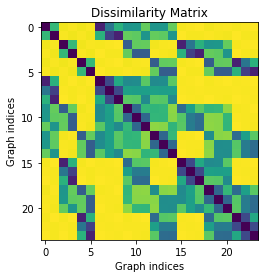

In [44]:
import graph_util
from matplotlib import pyplot as plt
import numpy as np

graph_list = [graphlib.library[i].graph for i in range(len(graphlib))]

diss_mat = graph_util.generate_dissimilarity_matrix(graph_list)

plt.imshow(diss_mat)
plt.xlabel('Graph indices')
plt.ylabel('Graph indices')
plt.title('Dissimilarity Matrix')

In [56]:
embeddings = graph_util.generate_embeddings(diss_mat, 128)

print(f'Shape of embeddings (numer of graphs, embedding size): {embeddings.shape}')

Shape of embeddings (numer of graphs, embedding size): (24, 128)


Text(0.5, 1.0, 't-SNE plot of extracted embeddings')

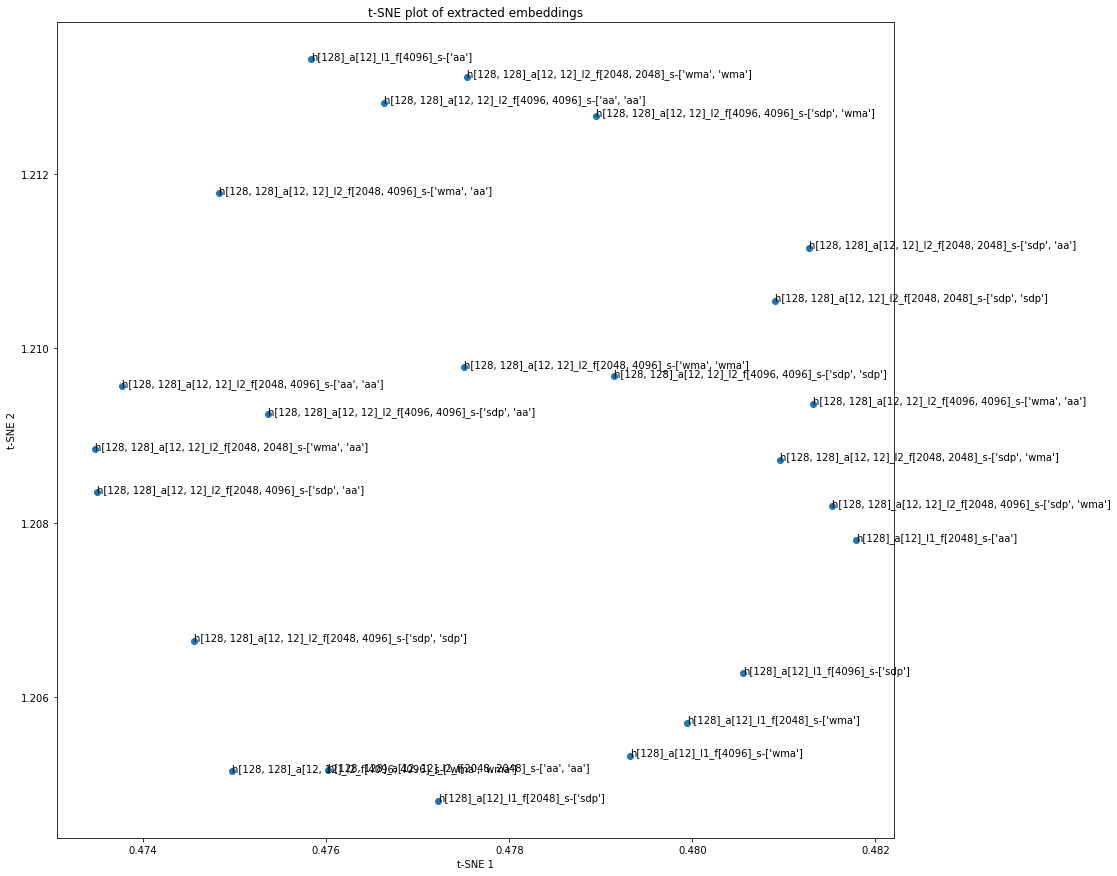

In [57]:
from sklearn.manifold import TSNE

two_dim = TSNE(n_components=2, learning_rate=20, perplexity=50).fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(two_dim[:, 0], two_dim[:, 1])

for i, txt in enumerate(
    [f"h{g.model_dict['h']}_a{g.model_dict['a']}_l{g.model_dict['l']}_f{g.model_dict['f']}_s-{g.model_dict['s']}" for g in graphlib.library]):
    ax.annotate(txt, (two_dim[i, 0], two_dim[i, 1]))
    
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE plot of extracted embeddings')